In [5]:
import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import my_utils as utils

importlib.reload(utils)

<module 'my_utils' from '/li_zhengdao/github/GenerativeGNN/my_utils.py'>

# Test list extend()

In [10]:
# Test list extend() then concate using numpy
res = []
l1 = [1,2,3]
l2 =[4,5,6]
res.append(l1)
res.append(l2)
res = np.array(res)
print(res.shape)

l3 = []

res1 = np.concatenate([res, l3], axis=-1)
print(res1.shape)

(2, 3)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

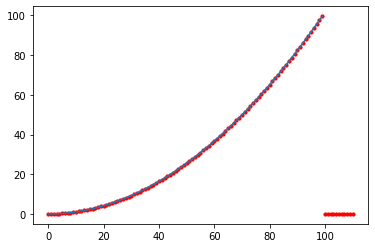

In [2]:
def downsampling(s:np.ndarray, sample_len=64):
    s_len = s.shape[0]
    if s_len <= sample_len:
        downsampled = np.pad(s, pad_width=(0, sample_len-s_len), mode='minimum')
        return np.arange(sample_len), downsampled
    
    indice = np.linspace(0, s_len-1, sample_len)
    int_idc = [int(i) for i in indice]
    downsampled = np.array([s[i] for i in int_idc])
    
    return int_idc, downsampled

x = np.arange(100)/10
sig = x**2 + 0.05*x**1.5

plt.figure()
plt.plot(sig)
int_idc, downsampled = downsampling(sig, sample_len=111)
plt.scatter(int_idc, downsampled, c='r', s=10)
plt.show()

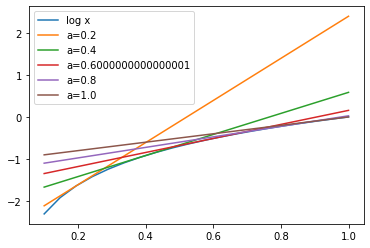

In [3]:
# plot log(x) <= x/a + log(a) - 1 

plt.figure()
x = np.linspace(0.1, 1, 20)
y = np.log(x)
a = list(np.linspace(0.2, 1, 5))
plt.plot(x, y, label='log x')
for aa in a:
    ya = x/aa + np.log(aa) - 1
    plt.plot(x, ya, label=f'a={aa}')
plt.legend()
plt.show()


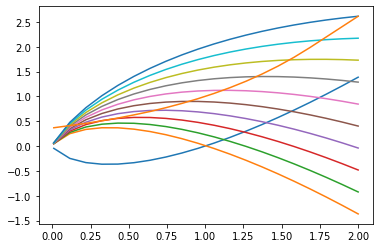

In [4]:
# Conjuagate function:

x = np.linspace(0.01, 2, 20)
fx = x * np.log(x)

y = np.linspace(0.01, 2, 10)


plt.figure()
plt.plot(x, fx)
for yy in y:
    yx = x*yy - fx
    plt.plot(x, yx)
# plt.show()

# plot y:
yy = np.linspace(0.01, 2, 20)

ys = []
for y in yy:
    ys.append(np.max(x*y - fx))
plt.plot(yy, ys)
plt.show()

# test A^2

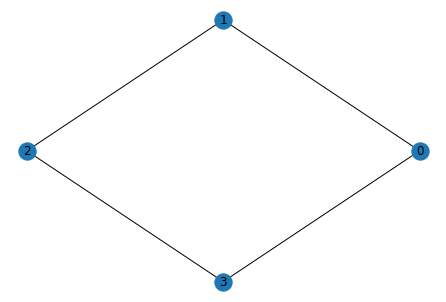

In [5]:
def norm_to_one(m):
    m[m>0]=1
    return m

def str2np(s):
    rows = s.split(',')
    
    row_len = len(rows)
    col_len = len(rows[0])
    
    res = np.ones(shape=(row_len, col_len))
    
    for i, r in enumerate(rows):
        for j, c in enumerate(r):
            res[i, j] = int(c)
    return res

def draw_g(adj):
    g = nx.from_numpy_array(adj)
    # pos = nx.nx_pydot.graphviz_layout(g1)
    nx.draw_circular(g, with_labels=True)

a = "0101,1010,0101,1010"

a = str2np(a)
I = np.eye(4)

aa = a + I

draw_g(a)

In [4]:
g = nx.cycle_graph(3)
g1 = nx.Graph()

nx.set_node_attributes(g, [1,2,4], 'labels')

print(type(g), g.nodes[1]['labels'])
g.__class__()
print('2:', type(g), g.nodes[1]['labels'])


<class 'networkx.classes.graph.Graph'> [1, 2, 4]
2: <class 'networkx.classes.graph.Graph'> [1, 2, 4]


In [8]:
a2 = a @ a
print('a:', a)
print('a*a2:', a*a2)

a: [[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]
a*a2: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [8]:
a3 = a2_adj @ a

print(a3)

[[2. 1. 2. 1.]
 [1. 2. 1. 2.]
 [2. 1. 2. 1.]
 [1. 2. 1. 2.]]


D: [[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]
a: [[0. 1. 1. 0.]
 [1. 0. 1. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]]
aa: [[1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 1.]]
a*a2: [[0. 1. 1. 0.]
 [1. 0. 1. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]]


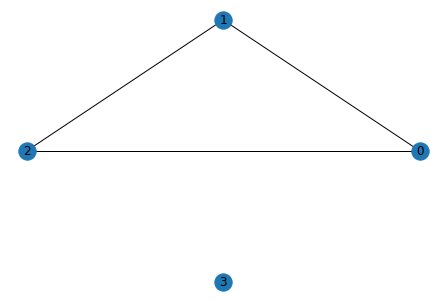

In [9]:

a = "0110,1010,1100,0000"

a = str2np(a)
draw_g(a)
I = np.eye(4)
aa = a + I

D = np.diag(np.sum(a, axis=1))

print('D:', D)
a2 = a @ a
aa2 = aa @ aa


a2 = a @ a
print('a:', a)
print('aa:',aa)
print('a*a2:', a*a2)

[[ 0.  1.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  1.  0.  0.]
 [ 0.  0.  0. -1.]]
[[2. 0. 0. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]]


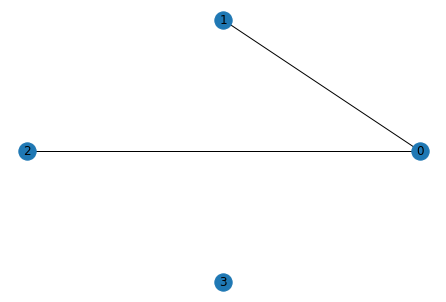

In [10]:

a = "0110,1000,1000,0000"

a = str2np(a)
draw_g(a)
I = np.eye(4)
aa = a + I

a2 = a @ a
a2_norm = norm_to_one(a2) - I

a2_adj = a2_norm + a
print(a2_adj)

a3 = a2_adj @ a

print(a3)

# $Cycle Count = A \odot A^2 - A$

In [11]:
cyc = a * a2 - a
print(cyc)

[[ 0. -1. -1.  0.]
 [-1.  0.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
